# TFIDF Vectorizer Models

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import ConvergenceWarning

## Import Data
We will be using the same data as the CountVectorize models. To make sure that the data is consistent we will follow the same steps for importing, cleaning, and creating the 'all_text' column. For more detailed commentary in this section, please refer to the Count Vectorizer Models notebook.

In [4]:
posts = pd.read_csv('../data/combined_genz_mill_posts.csv')

In [5]:
posts.head()

,title,selftext,subreddit
0,What have you learned this week?,NaN,r/GenZ
1,r/GenZ Is in need of more moderators! Read below:,"In the past few months, we've been getting inc...",r/GenZ
2,Who else remembers Net Neutrality and when thi...,NaN,r/GenZ
3,This sub lately.,NaN,r/GenZ
4,You guys are absolutely pathetic,Where do I even start? It's just constant comp...,r/GenZ


### Null Values

Instead of dropping any empty rows, we can combine the title and post content to create a new 'all_text' column filled with all the text in the post

In [4]:
posts.isna().sum()

title          0
selftext     543
subreddit      0
dtype: int64

In [5]:
posts['all_text'] = posts['title'] + ': ' + posts['selftext'].fillna('')

posts.head()

,title,selftext,subreddit,all_text
0,What have you learned this week?,NaN,r/GenZ,What have you learned this week?:
1,r/GenZ Is in need of more moderators! Read below:,"In the past few months, we've been getting inc...",r/GenZ,r/GenZ Is in need of more moderators! Read bel...
2,Who else remembers Net Neutrality and when thi...,NaN,r/GenZ,Who else remembers Net Neutrality and when thi...
3,This sub lately.,NaN,r/GenZ,This sub lately.:
4,You guys are absolutely pathetic,Where do I even start? It's just constant comp...,r/GenZ,You guys are absolutely pathetic: Where do I e...


In [6]:
# New 'all_text' column should have no null values
posts.isna().sum()

title          0
selftext     543
subreddit      0
all_text       0
dtype: int64

### Changing 'subreddit' to Numeric

Currently, the subreddit the post originated in is stored in the 'subreddit' column as a string. We need a numeric value to create our models.

In [7]:
posts['subreddit'].unique()

array(['r/GenZ', 'r/Millennials'], dtype=object)

We can create a new column that will be the target in our models based on whether the post is in r/GenZ

In [8]:
posts['is_gen_z'] = posts['subreddit'].map({'r/GenZ': 1, 'r/Millennials': 0})

In [9]:
posts['is_gen_z'].unique()

array([1, 0])

## Train/Test Split

To keep comparisons of our models consistent, we will split our train and test sets the same way we did in the count vectorizer notebooks.

In [10]:
X = posts['all_text']
y = posts['is_gen_z']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

### Baseline Accuracy
This method of splitting into train and test sets should also give us the same baseline accuracy as our other notebook.

In [11]:
y_train.value_counts(normalize=True)

is_gen_z
1    0.501948
0    0.498052
Name: proportion, dtype: float64

## Logistic Regression

In [12]:
pipe_tf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

To properly compare the difference between the count vectorizer and TFIDF vectorizer ws should test along the same parameters as we did for the last logistic regression.

In [13]:
pipe_params_tf = {
    'tvec__max_features': [2000, 3000, 4000, None],
    'tvec__min_df': [2, 4, .1],
    'tvec__max_df': [1.0, 0.9, 0.8],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tvec__strip_accents': ['ascii'],
    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none']
}

In [14]:
gs_tf = GridSearchCV(pipe_tf,
                 param_grid=pipe_params_tf,
                 n_jobs=-1)

In [ ]:
gs_tf.fit(X_train, y_train)

In [16]:
print(gs_tf.best_score_)
gs_tf.best_params_

0.72987012987013


{'lr__penalty': 'l2',
 'tvec__max_df': 1.0,
 'tvec__max_features': 2000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1),
 'tvec__strip_accents': 'ascii'}

In [20]:
print(f"Training score: {gs_tf.score(X_train, y_train)}")
print(f"Testing score: {gs_tf.score(X_test, y_test)}")

Training score: 0.8675324675324675
Testing score: 0.7668393782383419


**Interpretation:** Using a TFIDF Vectorizer did not improve our testing score, but it did decrease the amount the logistic regression model was overfit, while scoring better than the Naive Bayes model using a count vectorizer. I would not say that the improvement in overfitting makes up for the drop in it's test score, keeping the CountVectorizer Logistic Regression our top model so far.

### Confusion Matrix

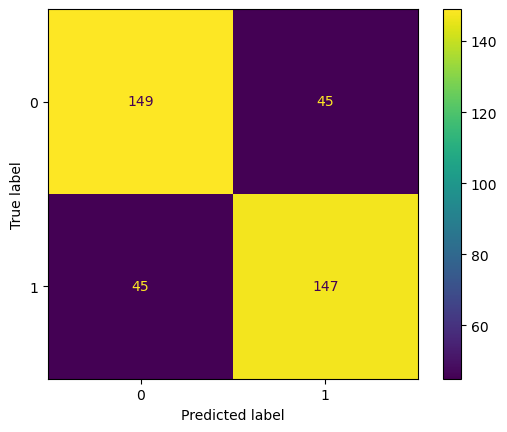

In [21]:
# Create Confusion Matrix
preds_tf = gs_tf.predict(X_test)
tn_tf, fp_tf, fn_tf, tp_tf = confusion_matrix(y_test, preds_tf).ravel()

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds_tf),
                             display_labels=gs_tf.classes_)
disp.plot();

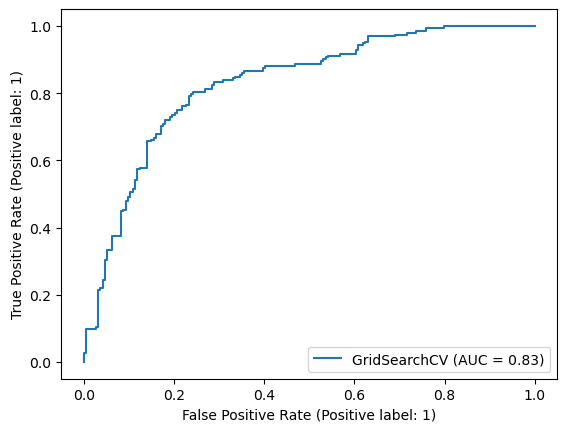

In [22]:
RocCurveDisplay.from_estimator(gs_tf, X_test, y_test);

**Interpretation:** This model had nearly equal false negatives and false positives. In practice, if we were using this model to determine who to serve ads to it may be better to advertise more rather than misclassifying Gen Z users as millennials and missing out on a potential sale. This would make it better to have false positives than false negatives, another reason to stick with the Count Vectorizer Models.

## Multinomial Naive Bayes

In [24]:
pipe_tfnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

We still want to keep these parameters similar to the Count Vectorizer models for consistent comparisons.

In [25]:
pipe_params_tfnb = {
    'tvec__max_features': [2000, 3000, 4000, None],
    'tvec__min_df': [2, 4, .1],
    'tvec__max_df': [1.0, 0.9, 0.8],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tvec__strip_accents': ['ascii']
}

In [26]:
gs_tfnb = GridSearchCV(pipe_tfnb,
                 param_grid=pipe_params_tfnb,
                 n_jobs=-1)

In [27]:
gs_tfnb.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [1.0, 0.9, 0.8],
                         'tvec__max_features': [2000, 3000, 4000, None],
                         'tvec__min_df': [2, 4, 0.1],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__strip_accents': ['ascii']})

In [28]:
print(gs_tfnb.best_score_)
gs_tfnb.best_params_

0.7025974025974027


{'tvec__max_df': 1.0,
 'tvec__max_features': 2000,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 1),
 'tvec__strip_accents': 'ascii'}

In [29]:
print(f"Training score: {gs_tfnb.score(X_train, y_train)}")
print(f"Testing score: {gs_tfnb.score(X_test, y_test)}")

Training score: 0.8512987012987013
Testing score: 0.7564766839378239


**Interpretation:** These results are very similar to our Logistic regression above, but scored slightly lower. This may be due to the fact that TFIDF Vectorizer and Naive Bayes are both techniques used to simplify models, so by combining them it may not be finding anything new about our features. Although, our TFIDF model for Naive Bayes did outperform the Count Vectorizer version.

### Confusion Matrix

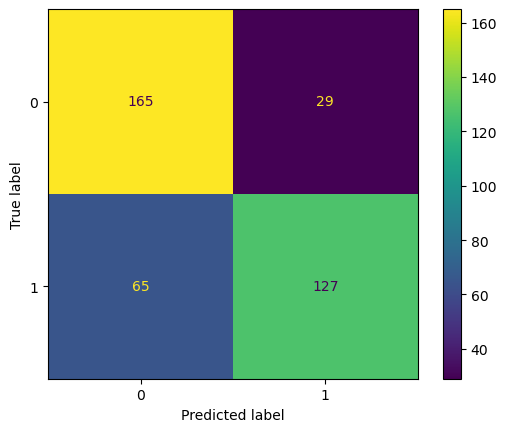

In [30]:
# Create Confusion Matrix
preds_tfnb = gs_tfnb.predict(X_test)
tn_tfnb, fp_tfnb, fn_tfnb, tp_tfnb = confusion_matrix(y_test, preds_tfnb).ravel()

# Plot Confusion Matrix
disp_tfnb = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds_tfnb),
                             display_labels=gs_tfnb.classes_)
disp_tfnb.plot();

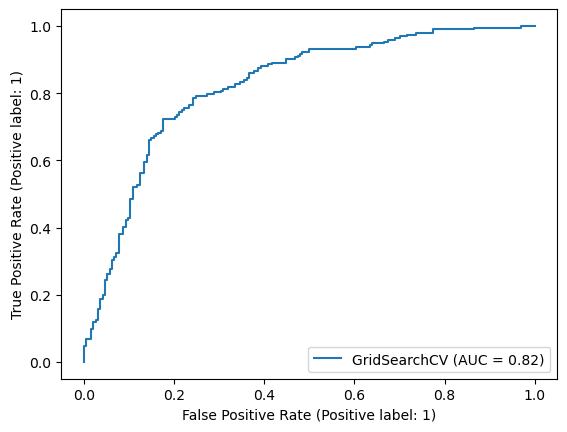

In [31]:
# Create Roc Curve
RocCurveDisplay.from_estimator(gs_tfnb, X_test, y_test);

**Interpretation:** This model tends towards many more false negatives than false positives. This means that if we were to use it to find Gen Z people to advertise to, it would incorrectly classify them as Millennials often, causing us to miss out on advertising opportunities. For practical purposes, it is much better for our model to classify a Millennial as Gen Z than the other way around.

# Executive Analysis

Based on the analysis and models created in this notebook and the Count Vectorizer notebook, I am confident that the Logistic Regression model using Count Vectorizer is the top performing model for our purposes. There are several reasons for that, the first simply being scoring. This model out performed all others with a test score of .79. Even though it appeared to be overfit, the model continued to score higher than any other combination of features. </br></br> The second reason is that it's errors are more practical than the other models. It tends to err on the side of classifying as Gen Z. This at least gives us opportunites to advertise, whereas an incorrect classification as Millennial does not. It is better to have a false positive because if the classification is incorrect, at least we were able to get an ad in front of somewhere, whereas with a false negative there is no attempt</br></br>Third, it is the most interpretable. If we need to justify our findings to another business team, the logistic regression is more straightforward than the other models. It is easier to see how the data is set up than with Naive Bayes or a TFIDF Vectorization, which will both make simplifications behind the scenes to try and improve performance.</br></br>After testing these models, I am recommending that the advertising team move forward with their plan of classifying users by generation based on the text they post, based on this Count Vectorizer Logistic Regression.
